<a href="https://colab.research.google.com/github/gowthambangaru/MNIST-/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 142MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 35.2MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 94.6MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



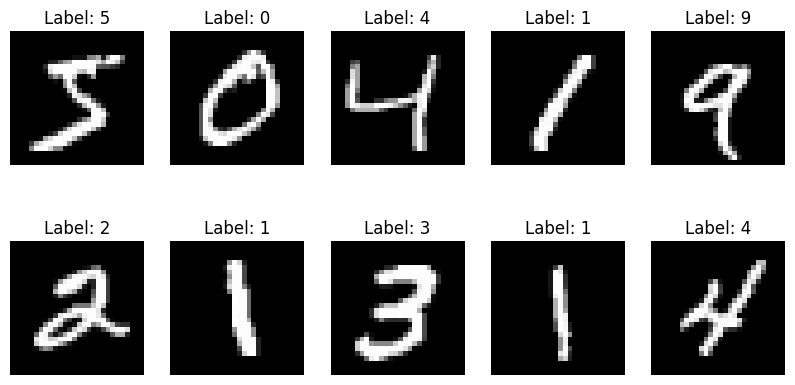

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load and transform MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Plot sample images from MNIST
def plot_sample_images(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        img, label = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

plot_sample_images(train_dataset)

In [3]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, output_size, activation='relu', weight_init='xavier'):
        super(FeedforwardNN, self).__init__()
        layers = []
        in_features = input_size

        for _ in range(hidden_layers):
            layer = nn.Linear(in_features, hidden_units)
            if weight_init == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif weight_init == 'random':
                nn.init.uniform_(layer.weight, -1, 1)
            layers.append(layer)

            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())

            in_features = hidden_units

        layers.append(nn.Linear(hidden_units, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")
    return model

In [7]:
input_size = 28 * 28
output_size = 10
hidden_layers = 3
hidden_units = 64
activation = 'relu'
weight_init = 'xavier'
epochs = 10
learning_rate = 1e-3
optimizer_choice = 'adam'

# Model and Loss Function
model = FeedforwardNN(input_size, hidden_layers, hidden_units, output_size, activation, weight_init)
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_dict = {
    'sgd': optim.SGD(model.parameters(), lr=learning_rate),
    'momentum': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
    'nesterov': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True),
    'rmsprop': optim.RMSprop(model.parameters(), lr=learning_rate),
    'adam': optim.Adam(model.parameters(), lr=learning_rate)
}

optimizer = optimizer_dict[optimizer_choice]

# Train the Model
model = train_model(model, train_loader, val_loader, optimizer, criterion, epochs)

Epoch [1/10], Loss: 0.3841, Validation Accuracy: 93.74%
Epoch [2/10], Loss: 0.1987, Validation Accuracy: 94.94%
Epoch [3/10], Loss: 0.1573, Validation Accuracy: 95.44%
Epoch [4/10], Loss: 0.1371, Validation Accuracy: 94.54%
Epoch [5/10], Loss: 0.1198, Validation Accuracy: 96.13%
Epoch [6/10], Loss: 0.1101, Validation Accuracy: 96.13%
Epoch [7/10], Loss: 0.0994, Validation Accuracy: 96.02%
Epoch [8/10], Loss: 0.0880, Validation Accuracy: 95.76%
Epoch [9/10], Loss: 0.0839, Validation Accuracy: 96.44%
Epoch [10/10], Loss: 0.0766, Validation Accuracy: 96.94%


Test Accuracy: 96.99%


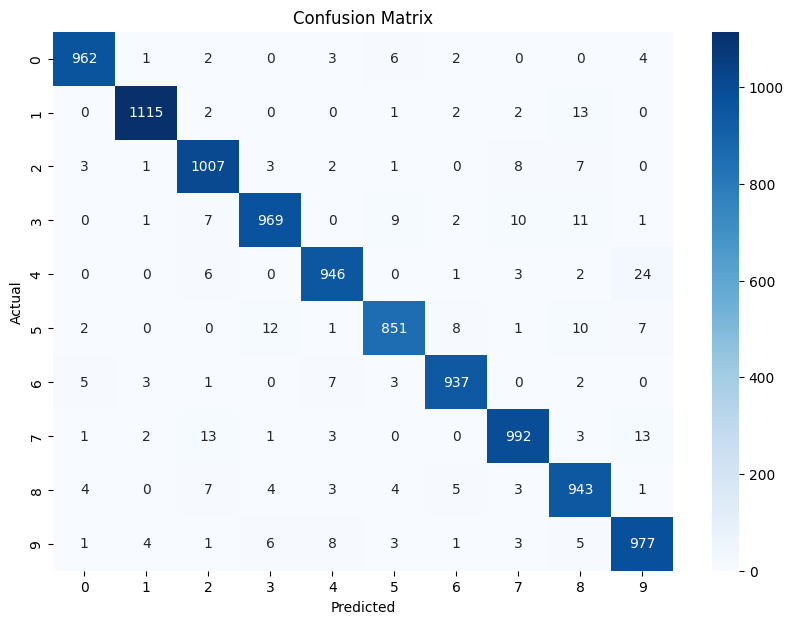

In [8]:

def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return all_labels, all_preds

all_labels, all_preds = evaluate(model, test_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
criterion_mse = nn.MSELoss()
loss_mse = criterion_mse(torch.nn.functional.one_hot(torch.tensor(all_labels), num_classes=10).float(),
                         torch.nn.functional.one_hot(torch.tensor(all_preds), num_classes=10).float())
print(f'MSE Loss: {loss_mse.item():.4f}')

MSE Loss: 0.0060
